In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
import itertools
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neighbors import KNeighborsRegressor
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.models import load_model
from numpy.random import seed
from statsmodels.stats.multitest import multipletests
from scipy.stats import ranksums
from more_itertools import powerset
from numpy import cov

%matplotlib inline
%config InlineBackend.figure_format = 'svg'    

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

sns.set()
warnings.filterwarnings('ignore')
random_seed = 10000
seed(random_seed)

Using TensorFlow backend.


In [2]:
df = pd.read_csv('houses_dataset.csv', index_col = 'Id')
df = df._get_numeric_data()
df = df.dropna(axis='columns')
df_rows = df.shape[0]
zero_precents = df.astype(bool).apply(lambda x: ~x).sum(axis = 0) / df_rows
zero_columns_labels = list(zero_precents[zero_precents > 0.333].index)
df = df.drop(zero_columns_labels, axis = 1)
df = df.drop(['KitchenAbvGr'], axis = 1)
df.head(10)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,BedroomAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,
1,60,8450,7,5,2003,2003,706,150,856,856,1710,2,3,8,2,548,2,2008,208500
2,20,9600,6,8,1976,1976,978,284,1262,1262,1262,2,3,6,2,460,5,2007,181500
3,60,11250,7,5,2001,2002,486,434,920,920,1786,2,3,6,2,608,9,2008,223500
4,70,9550,7,5,1915,1970,216,540,756,961,1717,1,3,7,3,642,2,2006,140000
5,60,14260,8,5,2000,2000,655,490,1145,1145,2198,2,4,9,3,836,12,2008,250000
6,50,14115,5,5,1993,1995,732,64,796,796,1362,1,1,5,2,480,10,2009,143000
7,20,10084,8,5,2004,2005,1369,317,1686,1694,1694,2,3,7,2,636,8,2007,307000
8,60,10382,7,6,1973,1973,859,216,1107,1107,2090,2,3,7,2,484,11,2009,200000
9,50,6120,7,5,1931,1950,0,952,952,1022,1774,2,2,8,2,468,4,2008,129900


## Correlation to Sale-Price

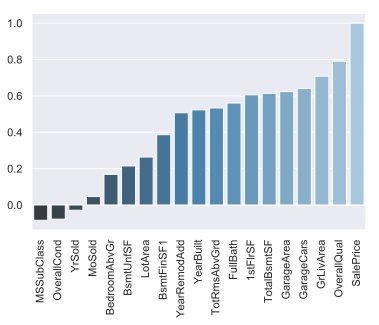

In [3]:
correlation = df.corr()['SalePrice'].sort_values()
dd = pd.DataFrame(correlation)
chart = sns.barplot(correlation.index, correlation.values, palette="Blues_d")
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [4]:
top_8_cats = abs(df.corr())['SalePrice'].sort_values(ascending=False)[::-1][:8]
for i, cat in enumerate(top_8_cats.index):
    print(str(i + 1) + ") " + cat)
data = df[list(top_8_cats.index) + ["SalePrice"]]

1) YrSold
2) MoSold
3) OverallCond
4) MSSubClass
5) BedroomAbvGr
6) BsmtUnfSF
7) LotArea
8) BsmtFinSF1


## Visualization

In [5]:
_ = sns.pairplot(data=data, y_vars=['SalePrice'], x_vars=data.columns, kind="reg", diag_kind="kde", plot_kws={'line_kws':{'color':'purple'}, 'scatter_kws': {'alpha': 0.2}})

# Correlation Heatmap

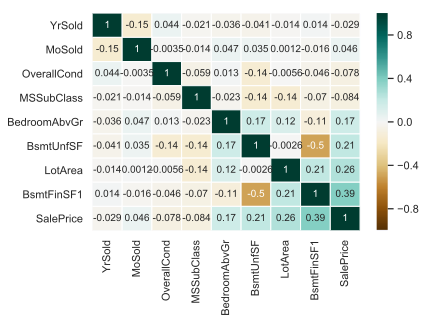

In [6]:
_ = sns.heatmap(data.corr(), cmap="BrBG", linewidths = 1, vmin = -1, vmax = 1, annot = True)

# Neural Network Training

In [7]:
test_precent = 0.2
train_precent = 1.0 - test_precent
train_data = data.sample(frac=train_precent, random_state=random_seed)
test_data = data.drop(train_data.index)

In [8]:
train_stats = train_data.describe().T
def normalize(x):
    result = x.copy()
    for feature_name in x.columns:
        average = x[feature_name].mean()
        std = x[feature_name].std()
        result[feature_name] = (x[feature_name] - average) / std
    return result
normalized_train_data = normalize(train_data)
normalized_test_data = normalize(test_data)
normalized_train_data.head()

,YrSold,MoSold,OverallCond,MSSubClass,BedroomAbvGr,BsmtUnfSF,LotArea,BsmtFinSF1,SalePrice
Id,,,,,,,,,
1356,-1.352675,0.967095,0.398656,0.542445,1.438914,-0.015288,-0.022447,-0.955570,-0.153046
1141,0.146304,-0.130993,1.297555,-0.874422,-1.075150,-1.068199,-0.314685,0.873802,-0.529172
491,0.146304,-0.130993,0.398656,2.431600,0.181882,-0.700800,-0.796434,-0.955570,-0.820366
449,-1.352675,-0.130993,0.398656,-0.165988,0.181882,0.455161,-0.186150,-0.955570,-0.765767
358,-0.603185,0.601066,-0.500244,1.487022,0.181882,-0.691839,-0.636125,0.921039,-0.589837


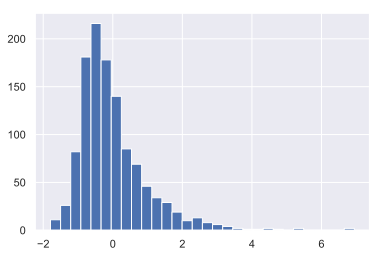

In [ ]:
_ = plt.hist(normalized_train_data['SalePrice'], bins = 30)

In [ ]:
train_x = normalized_train_data.drop('SalePrice', axis = 1)
train_y = normalized_train_data['SalePrice']
test_x = normalized_test_data.drop('SalePrice', axis = 1)
test_y = normalized_test_data['SalePrice']

In [ ]:
def build_fully_NN_model(train):
    input_layer    = Input(shape=(train.shape[1],))
    hidden_layer_1 = Dense(10, activation=tf.nn.relu)(input_layer)
    hidden_layer_2 = Dense(10, activation=tf.nn.relu)(hidden_layer_1)
    output_layer   = Dense(1)(hidden_layer_2)
   
    model = Model(input=[input_layer], output=[output_layer])
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    

    return model

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def train_model(model, X, Y, show_dots = True):
    mc = ModelCheckpoint('best_nn_model.nn', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)
    callbacks=[mc, es]
    if show_dots:
        callbacks.append(PrintDot())
    history = model.fit(X, Y, epochs=200, validation_split = 0.33, verbose=0, callbacks=callbacks)
    model = load_model('best_nn_model.nn')
    return history, model

In [ ]:
runs_amount = 7
runs = dict()
# j = 0
# for num_features in range(8 + 1):
#     for subset in itertools.combinations(range(8), num_features):
#         if len(subset) != 0:
#             features = [top_8_cats.index[i] for i in subset]
#             current_train_X = train_x[features]
#             current_train_Y = train_y
#             current_test_X = test_x[features]
#             current_test_Y = test_y
#             name = str(features)
#             runs[name] = []
#             for i in range(runs_amount):
#                 fully_NN_model = build_fully_NN_model(current_train_X)
#                 fully_NN_history, fully_NN_model = train_model(fully_NN_model, current_train_X, current_train_Y, False)
#                 loss, mse = fully_NN_model.evaluate(current_test_X, current_test_Y, verbose=0)
#                 runs[name].append(mse)
#             j += 1
#             pd.DataFrame(runs).transpose().to_csv('NN_test_set_prediction_results_full' + str(j) +'.csv')  
#             print('.', end='')
# pd.DataFrame(runs).transpose().to_csv('NN_test_set_prediction_results_full.csv')  
    

In [ ]:
def build_halved_model(group1, group2, group3, group4):
    input1 = Input(shape=(len(group1),))
    hidden1_1 = Dense(4, activation='relu')(input1)
    hidden1_2 = Dense(4, activation='relu')(hidden1_1)
    out1 = Dense(1)(hidden1_2)
    
    input2 = Input(shape=(len(group2),))
    hidden2_1 = Dense(4, activation='relu')(input2)
    hidden2_2 = Dense(4, activation='relu')(hidden2_1)
    out2 = Dense(1)(hidden2_2)
    
    input3 = Input(shape=(len(group3),))
    hidden3_1 = Dense(4, activation='relu')(input3)
    hidden3_2 = Dense(4, activation='relu')(hidden3_1)
    out3 = Dense(1)(hidden3_2)
    
    input4 = Input(shape=(len(group4),))
    hidden4_1 = Dense(4, activation='relu')(input4)
    hidden4_2 = Dense(4, activation='relu')(hidden4_1)
    out4 = Dense(1)(hidden4_2)
    
    merge = concatenate([out1, out2, out3, out4], name='merge')
    #hidden = Dense(4, activation='relu')(merge)
    #hidden_x = Dense(4)(hidden)
    output = Dense(1)(merge)
    
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    
    return model
def calc_halved_NN_mse(g1, g2, g3, g4):
    halved_train_X = [train_x[g1], train_x[g2], train_x[g3], train_x[g4]]
    halved_train_Y = train_y
    halved_test_X = [test_x[g1], test_x[g2], test_x[g3], test_x[g4]]
    halved_test_Y = test_y
    name = (str(g1), str(g2), str(g3), str(g4))
    runs[name] = []
    for i in range(runs_amount):
        halved_model = build_halved_model(g1, g2, g3, g4)
        _, halved_model = train_model(halved_model, halved_train_X, halved_train_Y, False)
        _, mse = halved_model.evaluate(halved_test_X, halved_test_Y, verbose=0)
        runs[name].append(mse)

In [ ]:
iteration = 0

def sample_2_2_2_2():
    data = list(range(8))
    def do_op(index, group):
        group.append(data[index])
        del data[index]
    
    group1 = []
    group2 = []
    group3 = []
    do_op(np.random.randint(7 + 1), group1)
    do_op(np.random.randint(6 + 1), group1)
    do_op(np.random.randint(5 + 1), group2)
    do_op(np.random.randint(4 + 1), group2)
    do_op(np.random.randint(3 + 1), group3)
    do_op(np.random.randint(2 + 1), group3)
    return group1, group2, group3, data

for _ in range(50):
    subset1, subset2, subset3, subset4 = sample_2_2_2_2()
    g1 = [top_8_cats.index[i] for i in subset1]
    g2 = [top_8_cats.index[i] for i in subset2]
    g3 = [top_8_cats.index[i] for i in subset3]
    g4 = [top_8_cats.index[i] for i in subset4]
    for __ in range(runs_amount):
        mse = calc_halved_NN_mse(g1, g2, g3, g4)
        print('.', end= '')
    iteration += 1
    pd.DataFrame(runs).transpose().to_csv('NN_test_set_prediction_results' + str(iteration) + '.csv')

#scores = [calc_halved_NN_mse(group1, group2) for (group1, group2) in groups]
#merged_parametric_rank_sum['Halved_NN_MSE'] = scores

..............................................................................................................................................................

In [ ]:
pd.DataFrame(runs).transpose().to_csv('NN_test_set_prediction_results.csv')